In [1]:
import random
import pandas as pd
import warnings
from sklearn import *
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import optuna
import sqlalchemy
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ROCAUC


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [2]:
# !pip freeze > requirements.txt
#!pip install -r xgboost_requirements.txt

# Introduction

The XGBoost model was aimed to classify infividuals into three categories: Non-Diabetic, Pre-Diabetic, and Diabetic. Several techniques were employed and aimed to address the imbalancing in the dataset as a means to be able to accurate classify all categories.

# Check for Missing Values and Place a Random Seed

In [3]:
np.random.seed(42)
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [4]:
# Function to plot ROC curve using Yellowbrick
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):
    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Non-Diabetic',
                                        1: 'Pre-Diabetic',
                                        2: 'Diabetic'})

    # Fitting to the training data first then scoring with the test data
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()

    return visualizer

# Data Preprocessing

The initial step for preparing this model involverd loading and determining whether or not the dataset needed cleaning, such as handling missing variables if needed and one-hot encoding categorical variables. Numerical variables were normalized to ensure uniform scaling.

In [5]:
# Encode categorical variables using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

In [6]:
# Test train split baseline model
X = data.drop(columns=['Diabetes_012'])
y = data['Diabetes_012']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify= y_temp)

# Show the class distribution pre-imbalance address
print("Original class distribution:\n", y_train.value_counts())

Original class distribution:
 Diabetes_012
0.0    136769
2.0     22622
1.0      2964
Name: count, dtype: int64


# Baseline Model

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92     34193
         1.0       0.00      0.00      0.00       741
         2.0       0.53      0.19      0.28      5655

    accuracy                           0.85     40589
   macro avg       0.47      0.39      0.40     40589
weighted avg       0.80      0.85      0.81     40589

Precision: 0.8017404883010503
Recall: 0.8473478035921063
F1 Score: 0.8101806356670375


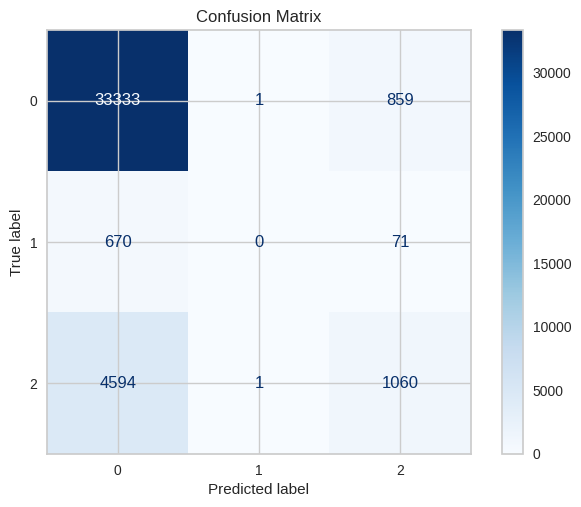

In [7]:
# Train the model with GPU
xgboost = XGBClassifier(use_label_encoder=True, eval_metric='logloss')
xgboost.fit(X_train, y_train)

# Prediction
y_val_pred = xgboost.predict(X_val)

# Evaluate the model
precision = precision_score(y_val, y_val_pred, average = 'weighted')
recall = recall_score(y_val, y_val_pred, average = 'weighted')
f1 = f1_score(y_val, y_val_pred, average = 'weighted')
baseline_report = classification_report(y_val, y_val_pred)

print(baseline_report)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

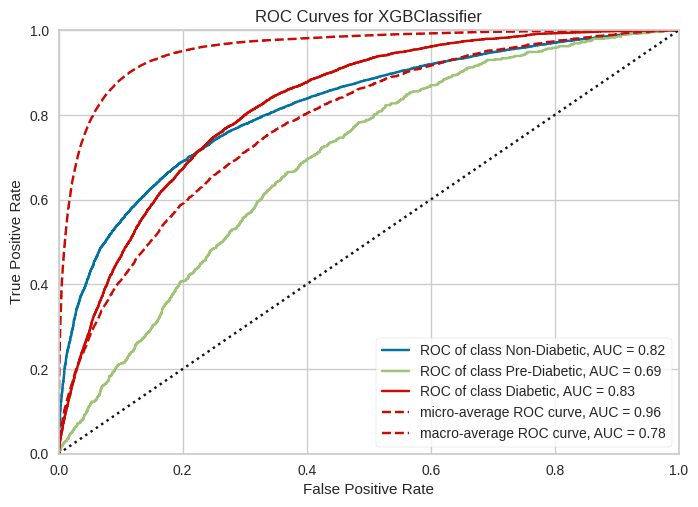

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Non-Diabetic', 1: 'Pre-Diabetic', 2: 'Diabetic'},
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enab...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))

In [8]:
# Plot ROC curve
plot_ROC_curve(xgboost, X_train, y_train, X_val, y_val)


# Analysis of Baseline XGBoost Model:

The confusion matrix show the following results for the three classes:

- Non-Diabetic (0): 33,333 correct predictions, 1 misclassified as Pre-Diabetic (1), and 859 misclassified as Diabetic (2).
 - Precision: 0.86
 - Recall: 0.97
 - F1-Score: 0.92
- Pre-Diabetic (1): 670 misclassified as Non-Diabetic (0), 71 misclassified as Diabetic (2), and 0 correct predictions.
 - Precision: 0.00
 - Recall: 0.00
 - F1-Score: 0.00
- Diabetic (2): 4,594 misclassified as Non-Diabetic (0), 1 misclassified as Pre-Diabetic (1), and 1,060 correct predictions.
 - Precision: 0.53
 - Recall: 0.19
 - F1-Score: 0.28

The ROC curve shows the follwing results for the each class:
- Non-Diabetic (0): AUC = 0.82
- Pre-Diabetic (1): AUC = 0.69
- Diabetic (2): AUC = 0.83
- Micro-Average ROC Curve: AUC = 0.96
- Macro-Average ROC Curve: AUC = 0.78

### Intepretation:

- The model performs exceptionally well in identifying Non-Diabetic individuals, as indicated by high precision (0.86), recall (0.97), and F1-score (0.92). The ROC curve with an AUC of 0.82 further confirms the model's robustness for this class.


- The model struggles significantly with the Pre-Diabetic class, achieving a precision, recall, and F1-score of 0.00. This indicates that the model fails to correctly identify any Pre-Diabetic individuals. The confusion matrix shows that all Pre-Diabetic samples are misclassified, primarily as Non-Diabetic. The ROC curve with an AUC of 0.69 suggests some ability to distinguish this class, but this is not reflected in the precision and recall scores.

- For the Diabetic class, the model shows moderate performance with a precision of 0.53, recall of 0.19, and F1-score of 0.28. The confusion matrix indicates that a significant portion of Diabetic samples are misclassified as Non-Diabetic. The ROC curve with an AUC of 0.83 indicates a reasonably good ability to distinguish Diabetic individuals.

The overall accuracy of the model is 0.85, which is driven mainly by the performance on the Non-Diabetic class. The macro-average metrics show lower values, highlighting the poor performance on the minority classes. The micro-average ROC curve with an AUC of 0.96 and the macro-average ROC curve with an AUC of 0.78 provide a comprehensive view of the model's performance, suggesting room for improvement.

# Modified XGBoost

In [9]:
df = data.copy()
# Separate features and target
X = df.drop(columns=['Diabetes_012'])
y = df['Diabetes_012']

# Split the data ensuring stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [10]:
# Feature engineering
# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

# Determine the desired sampling strategy for undersampling
class_counts = y_train_smote.value_counts()
desired_samples_per_class = class_counts.min()
undersample_strategy = {label: desired_samples_per_class for label in class_counts.index}

# Apply undersampling to the data after SMOTE
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_res, y_train_res = undersample.fit_resample(X_train_smote, y_train_smote)

# Check class distribution in the resampled training set
print("Class distribution after SMOTE and undersampling:")
print(y_train_res.value_counts())

# Apply PCA
pca = PCA(n_components=15)
X_train_res_pca = pca.fit_transform(X_train_res)
X_train_res_pca_df = pd.DataFrame(X_train_res_pca)
X_val_pca = pca.transform(X_val_imputed)
X_val_pca_df = pd.DataFrame(X_val_pca)

Class distribution after SMOTE and undersampling:
Diabetes_012
0.0    136769
1.0    136769
2.0    136769
Name: count, dtype: int64


## Addressing Class Imbalances

The application of Principal Component Analysis was employed to reduce the dimensionality of the dataset where this step not only helps in reducing computational load, but also aids in potentially enchancing model interpretability and performance.

The implementation if SMOTE and undersampling may seem counterintuitive at first but it has the potential to significantly improve the model. By combining SMOTE and undersampling, you can create a more balanced dataset. SMOTE addresses the lack of minority class samples, while undersampling ensures the majority class does not dominate the dataset.


              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     34193
         1.0       0.04      0.08      0.05       741
         2.0       0.36      0.57      0.44      5655

    accuracy                           0.76     40589
   macro avg       0.44      0.48      0.45     40589
weighted avg       0.82      0.76      0.79     40589

Precision: 0.822749024863465
Recall: 0.7604769765207322
F1 Score: 0.7852450957486503


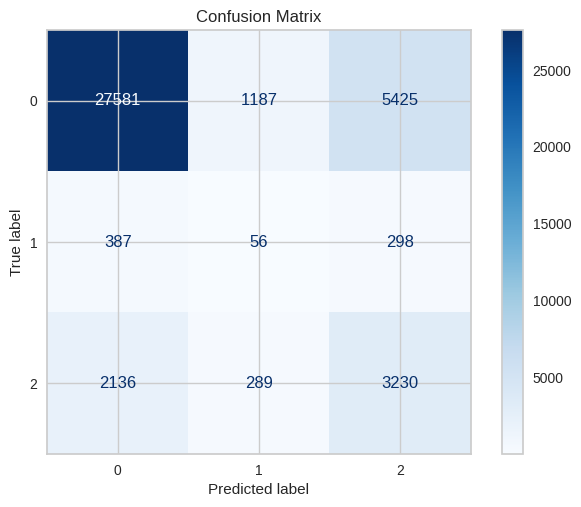

In [11]:
# Train a weighted XGBoost model without scale_pos_weight
xgb_model_weighted = XGBClassifier(use_label_encoder=True, eval_metric='logloss')
xgb_model_weighted.fit(X_train_res_pca, y_train_res)

# Prediction
y_val_pred_weighted = xgb_model_weighted.predict(X_val_pca)

# Evaluate the model
precision = precision_score(y_val, y_val_pred_weighted, average='weighted')
recall = recall_score(y_val, y_val_pred_weighted, average='weighted')
f1 = f1_score(y_val, y_val_pred_weighted, average='weighted')

print(classification_report(y_val, y_val_pred_weighted))
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred_weighted)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_weighted.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

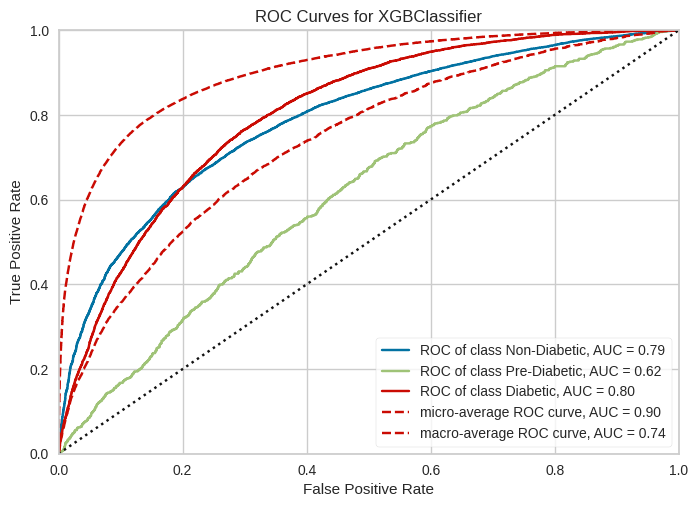

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Non-Diabetic', 1: 'Pre-Diabetic', 2: 'Diabetic'},
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enab...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))

In [12]:
# Plot ROC curve
plot_ROC_curve(xgb_model_weighted, X_train_res_pca, y_train_res, X_val_pca, y_val)


# Analysis of Modified XGBoost Model

Confusion Matrix
The confusion matrix shows the following results for the three classes:

- Non-Diabetic (0): 27,581 correct predictions, 1,187 misclassified as Pre-Diabetic (1), and 5,425 misclassified as Diabetic (2).
 - Precision: 0.92
 - Recall: 0.81
 - F1-Score: 0.86
- Pre-Diabetic (1): 387 misclassified as Non-Diabetic (0), 56 correct predictions, and 298 misclassified as Diabetic (2).
 - Precision: 0.04
 - Recall: 0.08
 - F1-Score: 0.05
- Diabetic (2): 2,136 misclassified as Non-Diabetic (0), 289 misclassified as Pre-Diabetic (1), and 3,230 correct predictions.
 - Precision: 0.36
 - Recall: 0.57
 - F1-Score: 0.44

The ROC curves provide the following AUC values for each class:

- Non-Diabetic (0): AUC = 0.79
- Pre-Diabetic (1): AUC = 0.62
- Diabetic (2): AUC = 0.80
- Micro-Average ROC Curve: AUC = 0.90
- Macro-Average ROC Curve: AUC = 0.74

### Interpretation:

- The model performs well in identifying Non-Diabetic individuals, with a high precision (0.92), recall (0.81), and F1-score (0.86). The ROC curve with an AUC of 0.79 supports the model's effectiveness for this class. Compared to the baseline model, the recall has decreased slightly, but the precision has improved, indicating fewer false positives.

- The model shows minimal improvement for the Pre-Diabetic class, achieving a precision of 0.04, recall of 0.08, and F1-score of 0.05.
The confusion matrix indicates that most Pre-Diabetic samples are still misclassified, but there is a slight improvement in recall.The ROC curve with an AUC of 0.62 suggests a modest ability to distinguish this class, but overall performance remains poor.

- The model's performance for the Diabetic class shows noticeable improvement, with a precision of 0.36, recall of 0.57, and F1-score of 0.44. The confusion matrix shows better identification of Diabetic individuals, with a significant number of correct predictions. The ROC curve with an AUC of 0.80 indicates a good discriminatory ability for this class.

The overall accuracy of the model is 0.76, a decrease from the baseline model. This decrease is expected due to the increased emphasis on identifying minority classes. The macro-average metrics have improved slightly, indicating better overall performance for the minority classes. The weighted average metrics show a balanced performance, with the model maintaining a good overall precision and recall.The modified model with SMOTE, undersampling, and PCA shows a better balance in identifying minority classes at the cost of slightly lower overall accuracy.



# Hyperparameter Tuning for XGBoost Using Optuna

In [16]:
# Define the objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 0.4, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **param)

    # Define the scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    # Perform cross-validation
    scores = cross_validate(xgb_model, X_train_res_pca, y_train_res, cv=3, scoring=scoring)

    # Log each metric
    trial.set_user_attr('accuracy', scores['test_accuracy'].mean())
    trial.set_user_attr('precision', scores['test_precision'].mean())
    trial.set_user_attr('recall', scores['test_recall'].mean())
    trial.set_user_attr('f1', scores['test_f1'].mean())

    # Return the main metric to optimize
    return scores['test_f1'].mean()

# Ensure the directory for the database exists
db_path = "xgboost_study.db"

# Create an SQLite database URL
db_url = f"sqlite:///{db_path}"

pruner = optuna.pruners.MedianPruner()
# Create a study object with SQLite storage
study = optuna.create_study(direction='maximize', storage=db_url, study_name="xgb_study",pruner=pruner, load_if_exists=True)

# Number of trials
n_trials = 50

# Optimize
study.optimize(objective, n_trials=n_trials)

# Print best trial results
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (F1 Score): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Print additional metrics
print(f"  Accuracy: {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall: {best_trial.user_attrs['recall']}")
print(f"  F1 Score: {best_trial.user_attrs['f1']}")

# Save the optuna study
study.trials_dataframe().to_csv("xgboost_trials.csv")


[I 2024-06-22 21:03:36,637] Using an existing study with name 'xgb_study' instead of creating a new one.
[I 2024-06-22 21:04:50,560] Trial 0 finished with value: 0.6766253579892189 and parameters: {'n_estimators': 173, 'max_depth': 5, 'learning_rate': 0.09426698016661879, 'subsample': 0.7087375444849926, 'colsample_bytree': 0.9863176000786247, 'gamma': 0.2509265432443262, 'min_child_weight': 3}. Best is trial 0 with value: 0.6766253579892189.
[I 2024-06-22 21:07:13,723] Trial 1 finished with value: 0.7980557814925316 and parameters: {'n_estimators': 154, 'max_depth': 8, 'learning_rate': 0.11810573071684959, 'subsample': 0.9911580226024999, 'colsample_bytree': 0.8292775741009016, 'gamma': 0.19292434869000308, 'min_child_weight': 1}. Best is trial 1 with value: 0.7980557814925316.
[I 2024-06-22 21:10:52,334] Trial 2 finished with value: 0.9008209326537622 and parameters: {'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.1484597090053464, 'subsample': 0.7264301921095206, 'colsampl

Best trial:
  Value (F1 Score): 0.9189795492034835
  Params: 
    n_estimators: 300
    max_depth: 10
    learning_rate: 0.194061691410492
    subsample: 0.6303363772269595
    colsample_bytree: 0.8953166757738393
    gamma: 0.2014036318038944
    min_child_weight: 2
  Accuracy: 0.9193701301708233
  Precision: 0.9188991030978441
  Recall: 0.9193701301708233
  F1 Score: 0.9189795492034835


# Evaluate Modified Hyperparameterized XGBoost Model

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     34193
         1.0       0.02      0.01      0.01       741
         2.0       0.38      0.38      0.38      5655

    accuracy                           0.81     40589
   macro avg       0.43      0.43      0.43     40589
weighted avg       0.80      0.81      0.80     40589

Accuracy: 0.8061790140185765
Precision: 0.7985495782201053
Recall: 0.8061790140185765
F1 Score: 0.8023036996496308


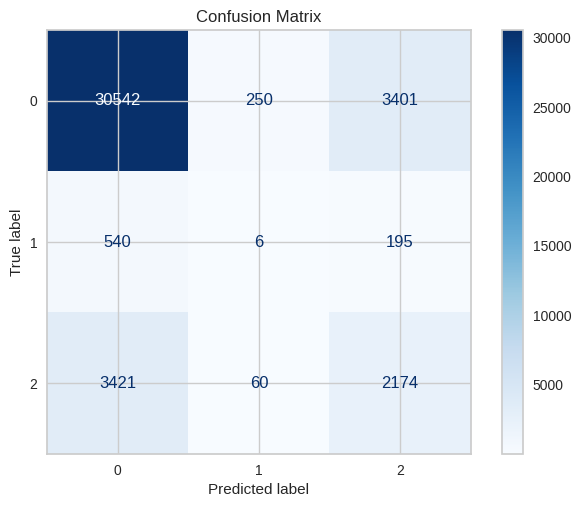

In [17]:
# Load the CSV file
#trials_df = pd.read_csv("xgboost_trials.csv")
# Identify the row with the best value (assuming higher is better for the objective)
#best_trial = trials_df.loc[trials_df['value'].idxmax()]

# Extract the best parameters
best_params = {
    'n_estimators': best_trial.params['n_estimators'],
    'max_depth': best_trial.params['max_depth'],
    'learning_rate': best_trial.params['learning_rate'],
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'gamma': best_trial.params['gamma'],
    'min_child_weight': best_trial.params['min_child_weight']
}

# Initialize the final XGBoost model with the best parameters
final_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Train the model on the entire training data
final_xgb_model.fit(X_train_res_pca, y_train_res)

# Make predictions on the validation set
y_val_pred = final_xgb_model.predict(X_val_pca)

# Evaluate the model using multiple metrics
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')
accuracy = final_xgb_model.score(X_val_pca, y_val)

print(classification_report(y_val, y_val_pred))
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


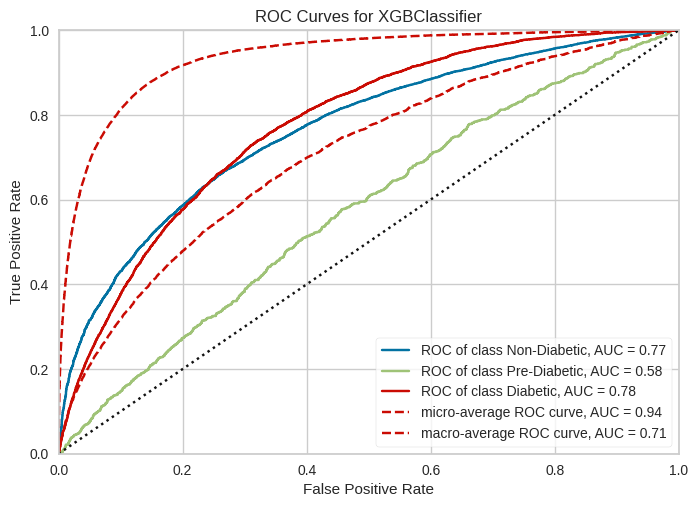

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Non-Diabetic', 1: 'Pre-Diabetic', 2: 'Diabetic'},
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8953166757738393, device=None,
                               early_stopping_ro...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.194061691410492, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))

In [18]:
plot_ROC_curve(final_xgb_model, X_train_res_pca, y_train_res, X_val_pca, y_val)


# Analysis of (Modified) Hyperparameterized XGBoost Model

The confusion matrix shows the following results for the three classes:

- Non-Diabetic (0): 30,542 correct predictions, 250 misclassified as Pre-Diabetic (1), and 3,401 misclassified as Diabetic (2).
 - Precision: 0.89
 - Recall: 0.89
 - F1-Score: 0.89
- Pre-Diabetic (1): 540 misclassified as Non-Diabetic (0), 6 correct predictions, and 195 misclassified as Diabetic (2).
 - Precision: 0.02
 - Recall: 0.01
 - F1-Score: 0.01
- Diabetic (2): 3,421 misclassified as Non-Diabetic (0), 60 misclassified as Pre-Diabetic (1), and 2,174 correct predictions.
 - Precision: 0.38
 - Recall: 0.38
 - F1-Score: 0.38

 The ROC curves provide the following AUC values for each class:

- Non-Diabetic (0): AUC = 0.77
- Pre-Diabetic (1): AUC = 0.58
- Diabetic (2): AUC = 0.78
- Micro-Average ROC Curve: AUC = 0.94
- Macro-Average ROC Curve: AUC = 0.71

### Interpretation:

- The model performs very well in identifying Non-Diabetic individuals, with high precision (0.89), recall (0.89), and F1-score (0.89). The ROC curve with an AUC of 0.77 indicates a robust ability to distinguish this class. Compared to the previous models, the precision, recall, and F1-score remain consistently strong, indicating stability in performance.

- The model continues to struggle significantly with the Pre-Diabetic class, achieving a precision of 0.02, recall of 0.01, and F1-score of 0.01. The confusion matrix shows that most Pre-Diabetic samples are misclassified, highlighting the challenge of identifying this class accurately. The ROC curve with an AUC of 0.58 indicates a limited ability to distinguish this class, and further improvements are necessary.

- For the Diabetic class, the model shows moderate performance with a precision of 0.38, recall of 0.38, and F1-score of 0.38. The confusion matrix shows an improved identification of Diabetic individuals compared to previous models, with a significant number of correct predictions. The ROC curve with an AUC of 0.78 indicates a strong ability to distinguish this class, consistent with the improvements seen.

The overall accuracy of the model is 0.81, which is a slight improvement from the modified model. The macro-average metrics have stabilized, indicating a consistent performance across classes, albeit with continued challenges for the Pre-Diabetic class. The weighted average metrics show a balanced and solid overall performance, reflecting the improvements made through hyperparameter tuning. The hyperparameterized model with Optuna shows a balanced and effective performance, with notable improvements for the Diabetic class. However, the Pre-Diabetic class still remains a challenge.

# Closing Remarks

In this study, we developed and evaluated three XGBoost models for the classification of diabetes status into three categories: Non-Diabetic, Pre-Diabetic, and Diabetic. The progression of our models included a baseline model, a modified model with SMOTE, undersampling, and PCA, and a hyperparameterized model tuned with Optuna.

- Baseline Model: The baseline model demonstrated high accuracy and strong performance for the Non-Diabetic class but struggled significantly with the Pre-Diabetic and Diabetic classes. The overall metrics were heavily influenced by the majority class.

- Modified Model: The modified model with SMOTE, undersampling, and PCA showed improved performance in identifying the Diabetic class, but the overall accuracy decreased due to a more balanced approach towards minority classes. The Pre-Diabetic class still faced significant challenges, with minimal improvements.

- Hyperparameterized Model: The hyperparameterized model tuned with Optuna achieved the best balance between precision, recall, and F1 score across all classes. Although it did not significantly improve the Pre-Diabetic class's performance, it demonstrated the highest overall stability and consistency.

### Recommendations:
Despite improvements, the Pre-Diabetic class remains a challenge. Future work should explore more sophisticated techniques for handling this class, such as targeted feature engineering and alternative oversampling methods.

### Conclusion:

The progression from a baseline model to a hyperparameterized model demonstrated significant improvements, particularly through the use of advanced techniques like SMOTE, undersampling, PCA, and hyperparameter optimization with Optuna. The hyperparameterized model stood out as the best performer, balancing accuracy and robustness across classes. Continued refinement and targeted strategies are essential for further improving classification performance, especially for the minority classes.

References:


Aggarwal, T. (2023, September 30). Master the power of optuna: A step-by-step guide. Medium. https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95

DiFrancesco, V. (2021, February 7). How to create an AUC ROC plot for A multiclass model. Medium. https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de

Marsland, S. (2015). Chapter 6: Dimensionality Reduction Section 6.2: Principal Component Analysis. In Machine Learning: An Algorithmic Perspective (2nd ed., pp. 133–137). essay, Chapman and Hall/CRC.